<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/Multilayer_Perceptron_Revisiting_market_Timing_of_APPL_stock_with_Hyper_parameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*In this notebook we revisit the timing our investments in AAPL stock under a regression problem using MLPs with Hyper-parameter tuning. This way, we will be able to observe first-hand the power of Hyper-parameter optimization (HPO). In order to complicate the predictability problem a bit over the classification example we went over in Lesson 2, and also to conveniently use the simplest form of the Keras Tuner, our predictive model MLP will be a regression one. As usual, we will first focus on the Deep Learning side of the task by building a predictive regression model with HPO, and later on check the performance of such a trading strategy in the test sample.*

## **1. Data and sources**

As we did in the example of Lesson 2, we will keep using the **yfinance** library to retrieve daily Apple stock price data from Yahoo! Finance:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

df = yf.download("AAPL", start="1980-01-01", end="2022-04-11")

df["Ret"] = df["Adj Close"].pct_change()
df.reset_index(inplace=True)

name = "Ret"

df.tail()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Ret
10415,2022-04-04,174.570007,178.490005,174.440002,178.440002,176.423889,76468400,0.023693
10416,2022-04-05,177.500000,178.300003,174.419998,175.059998,173.082062,73401800,-0.018942
10417,2022-04-06,172.360001,173.630005,170.130005,171.830002,169.888580,89058800,-0.018451
10418,2022-04-07,171.160004,173.360001,169.850006,172.139999,170.195053,77594700,0.001804
10419,2022-04-08,171.779999,171.779999,169.199997,170.089996,168.168213,76575500,-0.011909


## **2. Timing Apple stock with Multilayer Perceptron (MLPs)**

Now, let's start building our model in a similar fashion to what we have done in previous examples, starting with inputs and output variables:

### **2.1 Inputs and outputs**

For, among others, comparability reasons, we will consider the very same inputs for the regression model as we did for the classification example of Lesson 2. Specifically, those are AAPL stock returns from the past 25, 60, 90, 120 and 240 days:

In [2]:
df["Ret25_i"] = df[name].rolling(25).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret60_i"] = df[name].rolling(60).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret90_i"] = df[name].rolling(90).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret120_i"] = df[name].rolling(120).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret240_i"] = df[name].rolling(240).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))

del df["Open"]
del df["Close"]
del df["High"]
del df["Low"]
del df["Volume"]
del df["Adj Close"]

df = df.dropna()
df.tail(10)

,Date,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i
10410,2022-03-28,0.005037,0.053177,-0.002813,0.168500,0.239295,0.300388
10411,2022-03-29,0.019134,0.090150,0.019857,0.171149,0.252152,0.322116
10412,2022-03-30,-0.006650,0.109386,-0.011795,0.135913,0.236380,0.310361
10413,2022-03-31,-0.017776,0.074899,-0.016879,0.101120,0.221290,0.305399
10414,2022-04-01,-0.001718,0.060206,0.008005,0.096470,0.220199,0.300737
10415,2022-04-04,0.023693,0.082275,0.048402,0.117761,0.253071,0.336226
10416,2022-04-05,-0.018942,0.074954,0.028462,0.095510,0.238331,0.299128
10417,2022-04-06,-0.018451,0.035893,0.009890,0.108755,0.199571,0.277636
10418,2022-04-07,0.001804,0.039680,-0.005089,0.088668,0.193851,0.281901
10419,2022-04-08,-0.011909,0.046183,-0.019567,0.045156,0.170093,0.276003


- **Defining the output: Regression**

Then, we need to define our output variable. As we have already mentioned, we will face a regression problem here so our output is actually a continuous variable containing the returns of AAPL stock for some future time span.

In this case, our model will aim to predict the return of AAPL stock over the next **25 days**. Please note that this choice is completely subjective (the model may even work better for some other time span!). Once you have gone through the entire notebook and understood the basics of the process, please go ahead an play around with all these features!

In [3]:
df["Ret25"] = df["Ret25_i"].shift(-25)
df = df.dropna()
df.tail(10)

<ipython-input-3-5774a59d6d2a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ret25"] = df["Ret25_i"].shift(-25)


,Date,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Ret25
10385,2022-02-18,-0.009356,-0.022875,0.047863,0.183078,0.106527,0.365183,0.053177
10386,2022-02-22,-0.017812,-0.045792,0.026758,0.169481,0.097129,0.330748,0.090150
10387,2022-02-23,-0.025864,-0.052760,0.032575,0.123322,0.066758,0.312448,0.109386
10388,2022-02-24,0.016680,-0.015067,0.027381,0.132500,0.075968,0.304649,0.074899
10389,2022-02-25,0.012965,0.008245,0.008770,0.133661,0.084709,0.304872,0.060206
10390,2022-02-28,0.001638,0.022651,0.013615,0.120203,0.070848,0.312985,0.082275
10391,2022-03-01,-0.011628,0.015885,0.008115,0.105196,0.069303,0.335340,0.074954
10392,2022-03-02,0.020588,0.047867,0.040435,0.124330,0.096617,0.360494,0.035893
10393,2022-03-03,-0.001981,0.046448,0.016946,0.127638,0.127778,0.330076,0.039680
10394,2022-03-04,-0.018408,0.030975,-0.036899,0.109543,0.105448,0.318518,0.046183


In [4]:
df.describe()

,Date,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Ret25
count,10155,10155.000000,10155.000000,10155.000000,10155.000000,10155.000000,10155.000000,10155.000000
mean,2002-01-05 22:59:01.506647040,0.001179,0.029462,0.071034,0.105704,0.139633,0.275002,0.029319
min,1981-11-24 00:00:00,-0.518692,-0.940299,-1.151643,-1.040123,-1.048317,-0.902589,-0.940299
25%,1991-12-09 12:00:00,-0.012821,-0.048475,-0.048462,-0.046201,-0.044289,-0.049322,-0.048641
50%,2002-01-03 00:00:00,0.000000,0.035281,0.084316,0.120979,0.158937,0.295033,0.035281
75%,2012-02-01 12:00:00,0.014588,0.115271,0.211586,0.265631,0.315653,0.567630,0.114891
max,2022-03-04 00:00:00,0.332281,0.882471,0.892261,1.141607,1.301160,1.782616,0.882471
std,NaN,0.028211,0.141522,0.226865,0.279763,0.321760,0.447824,0.141492


### **2.2 Train-Test samples and Scaling**

The next important step, as you know, is in defining our train and test samples, together with the scaling of variables.

Now, as you may remember, we did not perform any scaling in the example from Lesson 2, and that is because all of the input and output variables are essentially of the same nature (i.e., stock returns), but note that it is common (and good) practice to perform the scaling. You can incorporate the scaling here by relying on what we did in the last module of ML. Indeed, you can actually try check whether different scaling methods matter for the predictions.

As for the definition of test and train samples, we will devote the usual first 60% of examples in that data (in chronological order) to training and the remaining 40% to testing:

In [5]:
ts = int(0.4 * len(df))  # Number of observations in the test sample
split_time = len(df) - ts  # From this data we are in the test sample
test_time = df.iloc[split_time:, 0:1].values  # Keep the test sample dates
Ret_vector = df.iloc[split_time:, 1:2].values
df.tail()

,Date,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Ret25
10390,2022-02-28,0.001638,0.022651,0.013615,0.120203,0.070848,0.312985,0.082275
10391,2022-03-01,-0.011628,0.015885,0.008115,0.105196,0.069303,0.335340,0.074954
10392,2022-03-02,0.020588,0.047867,0.040435,0.124330,0.096617,0.360494,0.035893
10393,2022-03-03,-0.001981,0.046448,0.016946,0.127638,0.127778,0.330076,0.039680
10394,2022-03-04,-0.018408,0.030975,-0.036899,0.109543,0.105448,0.318518,0.046183


So let's formally split our data in train and test samples for input and output variables:

In [6]:
from sklearn.model_selection import train_test_split

Xdf, ydf = df.iloc[:, 2:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, shuffle=False
)  # It is important to keep "shuffle=False"
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6093, 5) (4062, 5) (6093,) (4062,)


### **2.3 Model and Training**

Finally, it is time to set up our model. This is where the new things in the lesson come, which mainly sum up to one: **Keras Tuner**.

* **Keras Tuner**

Keras Tuner is a library that helps us in Hyper-parameter tuning for our TensorFlow programs. The functioning of the library is fairly easy an intuitive, with some specific syntax that you should be aware of. Despite that we will be using the Keras Tuner in this and future notebooks, we strongly recommend that you take a look at some extra resources:

- This simple tutorial from the TensorFlow website: https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=en


- There are multiple online examples and tutorials on how to use the Keras Tuner, here you have one that you can consult for clarification: https://www.youtube.com/watch?v=6Nf1x7qThR8

- Keras Tuner **library documentation**: https://keras.io/api/keras_tuner/

\
Now the Keras Tuners works in a rather simple way, but it requires us to perform tasks in an organized way. Let's see how.

First we will need to import the library, of course:

In [8]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [9]:
import keras_tuner as kt
import tensorflow as tf
from keras_tuner import HyperModel

\
Then, in addition to setting the random seed for replicability and the validation split for the use of early-stopping later on, we need to define a function **build()** within the **MLP_model** class.

This build function contains the different 'choices' we are going to ask the Keras Tuner to decide for us. In this first and simple example we are simply tuning 3 hyper-parameters:

- **Dropout**: we are letting the tuner choose between a value for dropout of 0.2 or 0.3.

- **Number of layers in the model**: in this case, we will let the tuner choose between 1 and 5 hidden layers in the model. We do this using the **hp.Int()** method.

- **Number of units in each hidden layer**: the tuner will choose between 1 (min_value) and 25 (max_value) units in each layer, with a step size of 5.

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)
val_split = 0.2


class MLP_model(HyperModel):
    def build(self, hp):
        # We define a constant activation function of ReLU form. We will not be tuning the activation functions
        act_fun = "relu"

        # We do ask the Keras Tuner to choose whether is best to have a dropout rate after each hidden layer of 0.2 or 0.3
        n_dropout = hp.Choice("n_dropout", values=[0.20, 0.30])

        model = tf.keras.models.Sequential()

        # Now, we will use a loop to let the tuner choose the number of layers that is best for the model between 1 and 5
        for i in range(1, hp.Int("num_layers", 1, 5)):
            # Within this loop, we will also ask the tuner to decide the optimal number of units that each of the selected layer should have.
            model.add(
                tf.keras.layers.Dense(
                    units=hp.Int(
                        "units_dense_" + str(i), min_value=1, max_value=25, step=5
                    ),
                    activation=act_fun,
                )
            )
            model.add(tf.keras.layers.Dropout(n_dropout))

        model.add(tf.keras.layers.Dense(units=1))

        # As was the case with the activation function, there is no tuning on the learning rate, nor the optimizer, although we could easily incorporate it.
        hp_lr = 1e-5
        adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
        model.compile(optimizer=adam, loss="mean_absolute_error")

        return model

\
Now, once we have defined our HyperModel (i.e., **MLP_model()** class), we can perform the tuning of the hyper-parameters. This is, essentially, another optimization algorithm (**Tuner**), for which we would also need to make some decisions:

- **Hypermodel**: we have already defined our hypermodel: MLP_model()

- **Objective**: what is the objective function to optimize? In this case we will minimize the loss function in the validation set.

- **Other parameters**: these include whether we overwrite results, fixing the random seed, or storage of results (convenient for large complex models).

\
But what about the **Tuner**? In this case, we will select the Hyperband tuner embedded in Keras, for which you can consult the documentation here: https://keras.io/api/keras_tuner/tuners/hyperband/#hyperband-class

\
Arguably, you could easily have decided to use another kind of optimizer from the ones available in the Keras Tuner (https://keras.io/api/keras_tuner/tuners/). Feel free to come back here once you have completed the notebook and see what would happen under another tuner!

In [11]:
import os

from keras import backend as K

# First, we clear the session just to make sure our seeds are correctly working and replicability is achieved
K.clear_session()

# Then, we call the model and perform the tuning:
hypermodel = MLP_model()
tuner = kt.Hyperband(
    hypermodel,
    objective=kt.Objective("val_loss", direction="min"),
    overwrite=True,
    max_epochs=30,
    seed=1234,
    directory=os.path.normpath("C:/"),
)

# Let's run the tuner! (Warning: this could take time)
tuner.search(X_train, y_train, validation_split=val_split)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 00m 17s]
val_loss: 0.10593278706073761

Best val_loss So Far: 0.09812446683645248
Total elapsed time: 00h 08m 21s


In [12]:
best_hps.values

{'n_dropout': 0.2,
 'num_layers': 3,
 'units_dense_1': 16,
 'units_dense_2': 16,
 'units_dense_3': 1,
 'units_dense_4': 16,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0078'}

Notice how the tuning algorithm computes the units for a number of layers (up to 4) but then it only considers 3 hidden layers as the 'optimal choice'. Moreover, given the format that the HPO works, a number of layers of 3 corresponds to actually 2 hidden (intermediate, so to speak) layers. These 2 hidden layers will have 6 and 21 units, respectively, as we will see later on.

Now, we can use these tuned hyper-parameter values to train our model, together with a usual early-stopping criteria:

In [13]:
model = tuner.hypermodel.build(best_hps)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=20, restore_best_weights=True
)

# fit the model
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
)

Epoch 1/500
153/153 - 1s - loss: 0.2393 - val_loss: 0.2109 - 1s/epoch - 8ms/step
Epoch 2/500
153/153 - 0s - loss: 0.2340 - val_loss: 0.2019 - 305ms/epoch - 2ms/step
Epoch 3/500
153/153 - 0s - loss: 0.2255 - val_loss: 0.1936 - 297ms/epoch - 2ms/step
Epoch 4/500
153/153 - 0s - loss: 0.2187 - val_loss: 0.1859 - 307ms/epoch - 2ms/step
Epoch 5/500
153/153 - 0s - loss: 0.2119 - val_loss: 0.1787 - 327ms/epoch - 2ms/step
Epoch 6/500
153/153 - 0s - loss: 0.2067 - val_loss: 0.1720 - 315ms/epoch - 2ms/step
Epoch 7/500
153/153 - 0s - loss: 0.2021 - val_loss: 0.1658 - 306ms/epoch - 2ms/step
Epoch 8/500
153/153 - 0s - loss: 0.1963 - val_loss: 0.1604 - 319ms/epoch - 2ms/step
Epoch 9/500
153/153 - 0s - loss: 0.1909 - val_loss: 0.1556 - 318ms/epoch - 2ms/step
Epoch 10/500
153/153 - 0s - loss: 0.1867 - val_loss: 0.1509 - 305ms/epoch - 2ms/step
Epoch 11/500
153/153 - 0s - loss: 0.1841 - val_loss: 0.1465 - 336ms/epoch - 2ms/step
Epoch 12/500
153/153 - 0s - loss: 0.1790 - val_loss: 0.1427 - 303ms/epoch - 2

\
This is how our 'tuned' model design will look like, with a total of 2 hidden layers (with 6 and 21 units) and a final output layer:

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                96        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


\
And here we will end the deep learning part of our task today! We have built a somewhat simple model using hyper-parameter tuning. Now, let's see whether the predictions (out-of-sample, of course) of this model are actually useful in a trading strategy for the test period selected.

## **3. Financial performance of the model**

Now, we will check if the predictions delivered in the test sample are valid for developing a trading strategy!

### **3.1 Backtesting out-of-sample (in test sample)**

As usual, we will now perform a backtesting of a trading strategy based on the predictions of the model:

In [15]:
y_pred = model.predict(X_test)

127/127 [==============================] - 0s 1ms/step


In [16]:
df_predictions = pd.DataFrame(
    {
        "Date": test_time.flatten(),
        "Pred": y_pred.flatten(),
        "Ret": (Ret_vector.flatten()),
    }
)
df_predictions.tail()

,Date,Pred,Ret
4057,2022-02-28,0.037594,0.001638
4058,2022-03-01,0.038898,-0.011628
4059,2022-03-02,0.040949,0.020588
4060,2022-03-03,0.039463,-0.001981
4061,2022-03-04,0.036282,-0.018408


In [17]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df = df_predictions
df.tail()

,Date,Pred,Ret
4057,2022-02-28,0.037594,0.001638
4058,2022-03-01,0.038898,-0.011628
4059,2022-03-02,0.040949,0.020588
4060,2022-03-03,0.039463,-0.001981
4061,2022-03-04,0.036282,-0.018408


\
As we have done other times before, we will compute the returns of 3 strategies in the test period:

- **Buy and hold**: simply buys the stock at the beginning of the test period and holds it until the end.

- **Long-only**: this strategy either goes long in the stock (if the predicted 25-day return is positive) or goes to cash (with a 0% return associated).

- **Long/Short** this strategy goes long (short) in the stock when the 25-day ahead return predicted by the model is positive (negative)

In [18]:
df["Positions"] = np.where(df["Pred"] > 0, 1, -1)
df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
df["Positions_L"] = df["Positions"].shift(1)
df["Positions_L"][df["Positions_L"] == -1] = 0
df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]
df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

<ipython-input-18-c91a31ad190e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Positions_L"][df["Positions_L"] == -1] = 0


Strat Return Long Only = 3884.575195180268 %
Strat Return = 2307.8374311516827 %
Buy and Hold Return = 6133.93582413067 %


Judging by the numbers obtained here, it seems that, under these tuned hyper-parameters and, remember, for the testing period of our choice, our model does a fairly decent job in timing the AAPL stock. Let' better see it graphically:

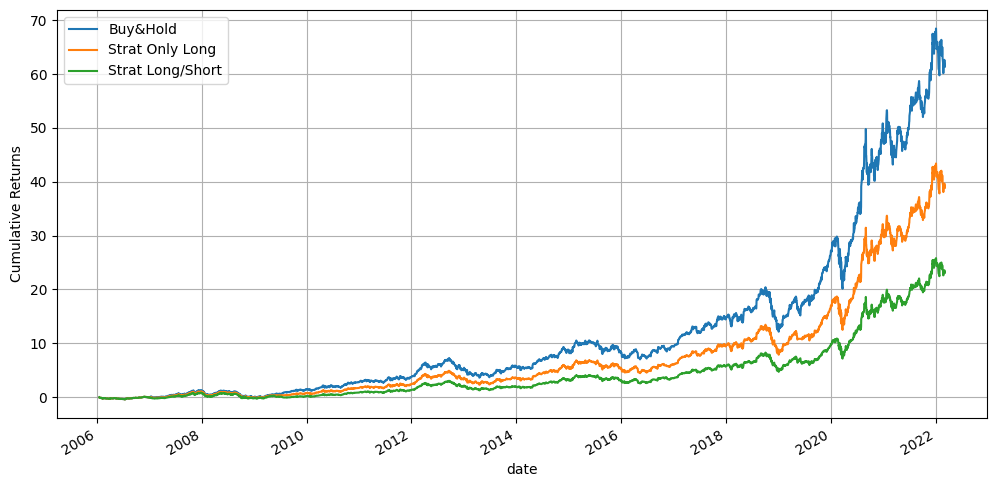

,Date,Pred,Ret,Positions,Strat_ret,Positions_L,Strat_ret_L,CumRet,CumRet_L,bhRet
count,4062,4062.000000,4062.000000,4062.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4062.000000
mean,2014-02-08 17:19:03.279172864,0.037534,0.001227,0.938454,0.000993,0.969219,0.001112,4.364152,7.435357,11.667949
min,2006-01-17 00:00:00,-0.047244,-0.179195,-1.000000,-0.179195,0.000000,-0.179195,-0.401841,-0.401841,-0.407992
25%,2010-01-28 06:00:00,0.029395,-0.008263,1.000000,-0.008502,1.000000,-0.007809,0.529252,0.947107,1.408312
50%,2014-02-10 12:00:00,0.039306,0.000942,1.000000,0.000743,1.000000,0.000256,2.478193,4.112653,6.232786
75%,2018-02-21 18:00:00,0.047208,0.011655,1.000000,0.011425,1.000000,0.011045,5.757003,9.516924,14.574338
max,2022-03-04 00:00:00,0.083541,0.139050,1.000000,0.139050,1.000000,0.139050,25.824347,43.389885,68.448733
std,NaN,0.016209,0.020451,0.345447,0.020465,0.172744,0.020182,5.679415,9.543757,15.088546


In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df.describe()

## **4. Conclusion**

In this last lesson of Module 1, we have implemented a basic tuning of model hyperparameters. Even though we have performed a somewhat simple tuning that focused on very few hyper-parameters, there are 2 things that we have likely come to realize: (i) tuning is computationally costly, and (ii) it can actually make a huge difference!.